In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sympy import Function, Derivative, Eq, symbols
from sympkf import Expectation, PDESystem, SymbolicPKF, FDModelBuilder, t

from module.tools import make_bivariate_ensemble
from module.ntbk3_routines import *
from module.multivariate import MultivariateEnKF1D, MultivariatePKF1D
from module.lh import *

# 1.  The simplified Chemical Transport Model  (CTM)<a class="anchor" id="introducing-simplified-ctm"></a>

## 1.1. The Lotka-Voltera dynamics as kinetic equations <a class="anchor" id="lv-kinetic"></a>

More precisely, the reactions take the form [Ladesmaki2016lect]
\begin{eqnarray}
A + X &\overset{k_1}{\rightarrow}& 2X, \,\, (1) \\
X + Y &\overset{k_2}{\rightarrow}& 2Y, \,\, (2) \\
Y &\overset{k_3}{\rightarrow}& B. \,\, (3) 
\end{eqnarray}

which remains to the reaction $A \rightarrow B$. The kinetic of the reaction, deduced from the **mass action law** _for reaction rate_ writes
\begin{eqnarray}
\frac{d[X]}{dt} &=& k_1 [A][X] - k_2 [X][Y],\\
\frac{d[Y]}{dt} &=& k_2 [X][Y] - k_3 [Y].
\end{eqnarray}
When the concentration of $A$ is constant (that is in excess), the system simplifies as 
\begin{eqnarray}
\frac{d[X]}{dt} &=& a [X] - b [X][Y],\\
\frac{d[Y]}{dt} &=& b [X][Y] - c [Y].
\end{eqnarray}

## 1.2.  The simplified CTM <a class="anchor" id="simplified-ctm"></a>

The one-dimensional conservative advection by a wind field $u$ of a tracer $\mathcal{X}$ is described by the partial differential equation $\partial_t \mathcal{X} + u \partial_x \mathcal{X} = -\mathcal{X} \partial_x u$. Therefore,  combining advection and chemical processes of two species $A$ and $B$, lead to the  bivariate chemical transport model :

$$
\left\lbrace
\begin{array}{}
\partial_t A + u \partial_x A &= -A\partial_x u + k_1 A - k_2 AB \\
\partial_t B + u \partial_x B &= -B\partial_x u +k_2 AB - k_3 B  \\
\end{array}
\right.
$$

We consider periodic boundary conditions.

In [2]:
x = symbols("x")
k1,k2,k3 = symbols("k_1 k_2 k_3")
u = Function("u")(x)  #wind
A = Function("A")(t,x)  #tracer A
B = Function("B")(t,x)  #tracer B

LV_dynamics = [
    Eq(Derivative(A,t),-u*Derivative(A,x) -A*Derivative(u,x) +k1*A -k2*A*B),
    Eq(Derivative(B,t),-u*Derivative(B,x) -B*Derivative(u,x) +k2*A*B -k3*B),
   ]

for eq in LV_dynamics:display(eq)

Eq(Derivative(A(t, x), t), k_1*A(t, x) - k_2*A(t, x)*B(t, x) - A(t, x)*Derivative(u(x), x) - u(x)*Derivative(A(t, x), x))

Eq(Derivative(B(t, x), t), k_2*A(t, x)*B(t, x) - k_3*B(t, x) - B(t, x)*Derivative(u(x), x) - u(x)*Derivative(B(t, x), x))

#### Automatic code generation for building classes

In [3]:
Nx=241*3

exec(FDModelBuilder(LV_dynamics, class_name='adv_lv').code)

#saving generated classes :
FDModelBuilder(LV_dynamics, class_name='adv_lv').write_module()

class adv_lv has been written in module adv_lv in file adv_lv.py


In [4]:
class EnKF_Advection_LV(MultivariateEnKF1D, adv_lv):
    def __init__(self, **kwargs):
        adv_lv.__init__(self, **kwargs)
        MultivariateEnKF1D.__init__(self, ['A','B']) 

In [5]:
enkf = EnKF_Advection_LV(shape=(Nx,))

domain = enkf

## 1.3. Wind and chemical rates settings

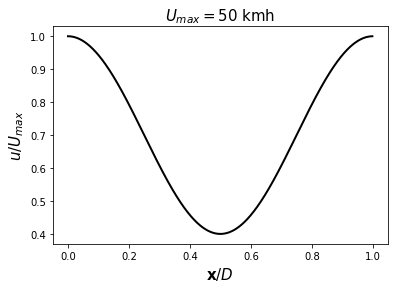

In [6]:
D = 1000  #km
u_amp = 15 #kmh
u_mean = 35  #kmh

u = (u_mean + u_amp*np.cos(2*np.pi*domain.x[0]))/D
Tadv = 1/u.mean()

enkf.u = u
enkf.k_1 = 0.075
enkf.k_2 = 0.065
enkf.k_3 = 0.085

plt.plot(domain.x[0], u/u.max(), c= 'k',linewidth=2)
plt.xlabel(r"$\mathbf{x}/D$",fontsize=15); plt.ylabel("$u/U_{max}$",fontsize=15);
plt.title('$U_{max}=$'+ f'{int(u.max()*D)} kmh',fontsize=15);

# 2. Design of a multivariate covariance model for the PKF <a class="anchor" id="Data-assimilation"></a>


We aim to build a formula for approximating cross-correlation functions : this formula has to rely only on some parameters.

We suggest the following approximation :

$$
r_{AB}(\mathbf{x},\mathbf{y}) = \frac{1}{2}\left(\frac{V^{AB}_\mathbf{x}}{\sigma^A_\mathbf{x} \sigma^B_\mathbf{x}} + \frac{V^{AB}_\mathbf{y}}{\sigma^A_\mathbf{y} \sigma^B_\mathbf{y}} \right)\exp
\left(
- \frac{||\mathbf{x}-\mathbf{y}||^2}
{\frac{1}{2}(s^A_\mathbf{x} +s^A_\mathbf{y}+s^B_\mathbf{x}+s^B_\mathbf{y}) }
\right)
$$

__Notes__ : 
- this formula is symetric, although in practice it is not true. In the meantime, it makes full profit of all the information provided by the PKF system at locations $\mathbf{x}$ and $\mathbf{y}$.
- it is also a fully analytic approximations of the cross-correlation functions, therefore it has a very low computational cost.


## 2.1. Homogeneous case

### 2.1.1. Forecasting the simplified CTM with EnKF <a class="anchor" id="forecast-enkf"></a>

#### initial conditions

In [7]:
initial_setting = {
    "A":1.2,'B':.8,
    'Covariance AB': 0,
    'std A': 0.12,'std B': .08,
    'Length-scale A': lh,'Length-scale B': lh
}

In [8]:
ensemble_size = 6400
ensemble_state0 = make_bivariate_ensemble(ensemble_size, initial_setting, domain.x[0])

#### forecasting

In [9]:
dt = domain.dx[0]/u.max() #CFL condition
enkf.set_dt(dt)

times = enkf.window(3.0*Tadv, start=0)
saved_times = list(times[::30]) + [times[-1]]

#ensemble forecast:
traj_enkf = enkf.ensemble_forecast(times, ensemble_state0, saved_times)
diag_enkf = enkf.diagnosis(traj_enkf,[Nx//2],['A'])

### 2.1.2. Qualitative evalutation of the proxy

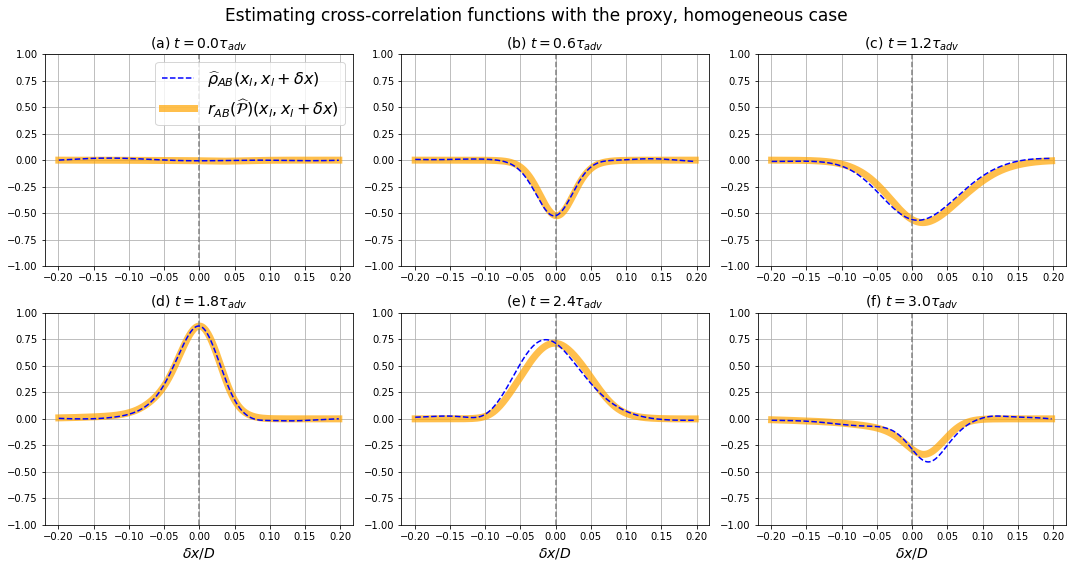

In [10]:
zoom_factor = 5
zoom = np.arange(Nx//2 - Nx//zoom_factor,Nx//2 + Nx//zoom_factor,1)

fig, ax = plt.subplots(2,3,figsize=(15,8))
n_stops = 6
times = np.array(list(traj_enkf.keys()))

stops = np.linspace(0,len(times)-1,n_stops).astype(int)
times_stop = [times[stop] for stop in stops]
times_stops = np.round(np.linspace(0,3,n_stops),2)

xx = np.linspace(-.5,.5,Nx); loc = Nx//2

label1 = r'$\widehat{\rho}_{AB}(x_l,x_l+\delta x)$'
label2 = r'$r_{AB}(\widehat{\mathcal{P}})(x_l,x_l+\delta x)$'
for i, (time,index) in enumerate(zip(times_stop,'abcdef')):
    modelization = crosscorrelation_model(*get_pkf_parameters(diag_enkf[time])[2:], loc, domain.x[0])
    empirical_cross_cor_func = enkf._formated_correlation_matrix(traj_enkf[time])['A']['B'][loc]
    
    ax.flat[i].plot(xx[zoom],empirical_cross_cor_func[zoom],label=label1,c='b',linestyle='--',zorder=3)
    ax.flat[i].plot(xx[zoom],modelization[zoom],label=label2,c='orange',alpha=.7,linewidth=7)
    
    ax.flat[i].grid();    ax.flat[i].axvline(0,linestyle='--',c='grey')
    ax.flat[i].set_title(f"({index}) $t={times_stops[i]}$" +r'$\tau_{adv}$',fontsize=14) ;ax.flat[i].set_ylim(-1,1)
    if i>2 : ax.flat[i].set_xlabel(r"$\delta x /D$",fontsize=14)
#     if i == 0 or i==3 : ax.flat[i].set_ylabel(r'$\rho_{AB}(x_l,x_l + \delta x)$',fontsize=16)
    if i == 0 : ax.flat[i].legend(prop={'size': 16});

        
label1 = r'$\hat{\rho}_{AB}(x_l,x_l+\delta x)$'        
plt.suptitle('Estimating cross-correlation functions with the proxy, homogeneous case',fontsize=17)
plt.tight_layout();
plt.savefig(f'../figures/Nx{Nx}/proxy_estimations_cc_homogeneous_Nx{Nx}_lh{lh}.png')

This formula allows for a good reconstruction of the cross-correlation functions.

### 2.1.3. Quantitative evalutation of the proxy

In [11]:
## COLLECTING TIME EVOLUTION of the relative error
relatives_errors_fro_homogeneous = []
for time in diag_enkf.keys():
    Pab_enkf = enkf._formated_correlation_matrix(traj_enkf[time])['A']['B']
    Pab_cov_model = np.vstack([
    crosscorrelation_model(*get_pkf_parameters(diag_enkf[time])[2:],
    loc, domain.x[0]) for loc in range(Nx)])

    fro_norm = np.linalg.norm(Pab_enkf - Pab_cov_model,'fro') / np.linalg.norm(Pab_enkf,'fro')
    relatives_errors_fro_homogeneous.append(fro_norm)

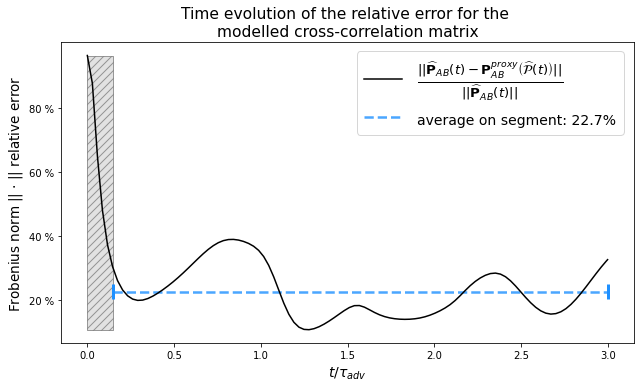

In [12]:
## PLOTTING TIME EVOLUTION


fig=plt.figure(figsize=(9,5.5))
label = r'$\frac{||\widehat{\mathbf{P}}_{AB}(t) - \mathbf{P}^{proxy}_{AB}\left(\widehat{\mathcal{P}}(t)\right)  ||}{|| \widehat{\mathbf{P}}_{AB}(t) ||}$'#+r', || $\cdot$ || Frobenius norm'
plt.plot(saved_times/Tadv, np.array(relatives_errors_fro_homogeneous) *100 ,c='k',label=label)

index_mean_homogeneous = np.arange(5, len(diag_enkf.keys())).astype(int)
times_mean_homogeneous = np.array(saved_times)[index_mean_homogeneous] 
mean_on_period_homogeneous = np.mean(np.array(relatives_errors_fro_homogeneous)[index_mean_homogeneous])*100

plt.plot(times_mean_homogeneous/Tadv,
         np.zeros(len(index_mean_homogeneous)) + mean_on_period_homogeneous,
        label=f'average on segment: {mean_on_period_homogeneous:.1f}%',c='dodgerblue',linestyle='--',
         zorder=1.0,linewidth=2.5,alpha=0.8)

plt.scatter(times_mean_homogeneous[[0,-1]]/Tadv, [mean_on_period_homogeneous]*2,marker='|',linewidth=3,s=[250]*2,c='dodgerblue')
yticks = [20,40,60,80]
yticklabels = [str(tick) +' %' for tick in yticks]
plt.yticks(ticks=yticks,labels=yticklabels)
plt.title("Time evolution of the relative error for the \nmodelled cross-correlation matrix",fontsize=15.5)
plt.xlabel(r'$t/\tau_{adv}$',fontsize=14);
plt.ylabel("Frobenius norm " +r'|| $\cdot$ ||' +" relative error",fontsize=13.5);

leg = plt.legend(prop={'size': 19})
label1, label2 = leg.get_texts()
label2._fontproperties = label1._fontproperties.copy()
label2.set_size('14')

plt.fill_betweenx([relatives_errors_fro_homogeneous[0]*100,np.min(relatives_errors_fro_homogeneous)*100],
                  times_mean_homogeneous[0]/Tadv,0,color='lightgrey',hatch='///', edgecolor='dimgrey',lw=1,zorder=0,alpha=.65)

# plt.legend(prop={'size': 18});,
fig.tight_layout();
fig.savefig(f'../figures/Nx{Nx}/time_evolution_relative_error_modelled_CCmat_homogeneous_Nx{Nx}_lh{str(lh)[2:]}')

## 2.2 Heterogeneous case

### 2.2.1. Forecasting the simplified CTM with EnKF <a class="anchor" id="forecast-enkf"></a>

#### initial conditions

In [13]:
initial_setting = {
    "A":1.2,'B':.8,
    'Covariance AB': 0,
    'std A': 0.12,'std B': .08,
    'Length-scale A': lhA,'Length-scale B': lhB
}

In [14]:
del ensemble_state0, traj_enkf, diag_enkf

ensemble_size = 6400
ensemble_state0 = make_bivariate_ensemble(ensemble_size, initial_setting, domain.x[0])

#### forecasting

In [15]:
dt = domain.dx[0]/u.max() #CFL condition
enkf.set_dt(dt)

times = enkf.window(3.0*Tadv, start=0)
saved_times = list(times[::30]) + [times[-1]]

#ensemble forecast:
traj_enkf = enkf.ensemble_forecast(times, ensemble_state0, saved_times)
diag_enkf = enkf.diagnosis(traj_enkf,[Nx//2],['A'])

### 2.2.2. Qualitative evalutation of the proxy

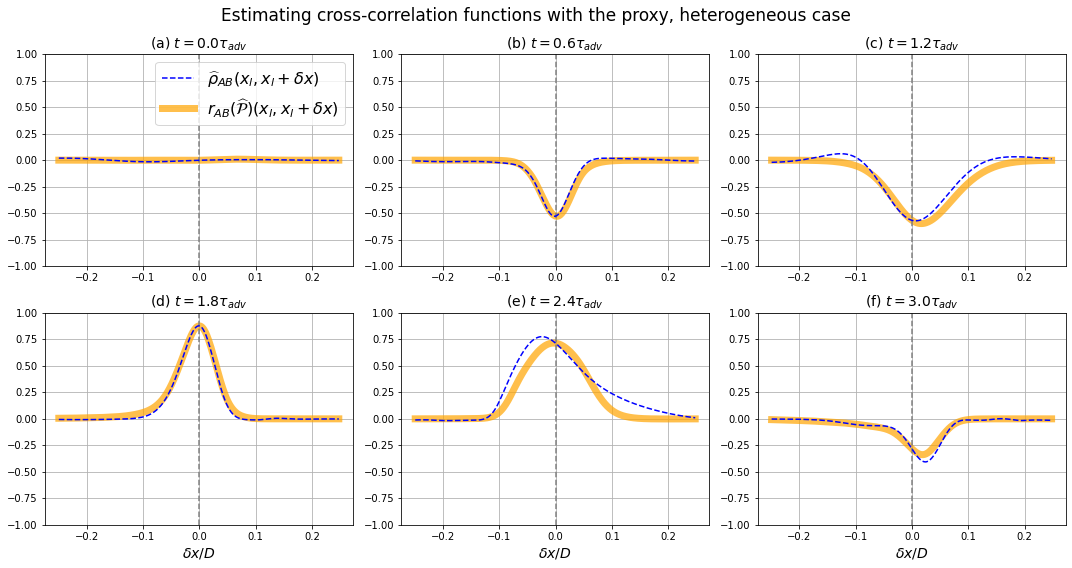

In [16]:
zoom_factor = 4
zoom = np.arange(Nx//2 - Nx//zoom_factor,Nx//2 + Nx//zoom_factor,1)

fig, ax = plt.subplots(2,3,figsize=(15,8))
n_stops = 6
times = np.array(list(traj_enkf.keys()))

stops = np.linspace(0,len(times)-1,n_stops).astype(int)
times_stop = [times[stop] for stop in stops]
times_stops = np.round(np.linspace(0,3,n_stops),2)

xx = np.linspace(-.5,.5,Nx); loc = Nx//2

label1 = r'$\widehat{\rho}_{AB}(x_l,x_l+\delta x)$'
label2 = r'$r_{AB}(\widehat{\mathcal{P}})(x_l,x_l+\delta x)$'
for i, (time,index) in enumerate(zip(times_stop,'abcdef')):
    modelization = crosscorrelation_model(*get_pkf_parameters(diag_enkf[time])[2:], loc, domain.x[0])
    empirical_cross_cor_func = enkf._formated_correlation_matrix(traj_enkf[time])['A']['B'][loc]
    
    ax.flat[i].plot(xx[zoom],empirical_cross_cor_func[zoom],label=label1,c='b',linestyle='--',zorder=3)
    ax.flat[i].plot(xx[zoom],modelization[zoom],label=label2,c='orange',alpha=.7,linewidth=7)
    
    ax.flat[i].grid();    ax.flat[i].axvline(0,linestyle='--',c='grey')
    ax.flat[i].set_title(f"({index}) $t={times_stops[i]}$" +r'$\tau_{adv}$',fontsize=14) ;ax.flat[i].set_ylim(-1,1)
    if i>2 : ax.flat[i].set_xlabel(r"$\delta x /D$",fontsize=14)
#     if i == 0 or i==3 : ax.flat[i].set_ylabel(r'$\rho_{AB}(x_l,x_l + \delta x)$',fontsize=16)
    if i == 0 : ax.flat[i].legend(prop={'size': 16});

        
label1 = r'$\hat{\rho}_{AB}(x_l,x_l+\delta x)$'        
plt.suptitle('Estimating cross-correlation functions with the proxy, heterogeneous case',fontsize=17)
plt.tight_layout();
plt.savefig(f'../figures/Nx{Nx}/proxy_estimations_cc_heterogeneous_Nx{Nx}_lhA{str(lhA)[2:]}_lhB{str(lhB)[2:]}')

This formula allows for a good reconstruction of the cross-correlation functions.

### 2.2.3. Quantitative evalutation of the proxy

In [17]:
## COLLECTING TIME EVOLUTION of the relative error
relatives_errors_fro_hetero = []
for time in diag_enkf.keys():
    Pab_enkf = enkf._formated_correlation_matrix(traj_enkf[time])['A']['B']
    Pab_cov_model = np.vstack([
    crosscorrelation_model(*get_pkf_parameters(diag_enkf[time])[2:],
    loc, domain.x[0]) for loc in range(Nx)])

    fro_norm = np.linalg.norm(Pab_enkf - Pab_cov_model,'fro') / np.linalg.norm(Pab_enkf,'fro')
    relatives_errors_fro_hetero.append(fro_norm)

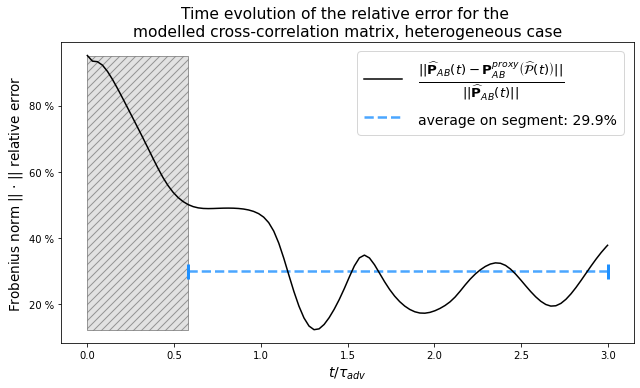

In [18]:
## PLOTTING TIME EVOLUTION
fig=plt.figure(figsize=(9,5.5))
label = r'$\frac{||\widehat{\mathbf{P}}_{AB}(t) - \mathbf{P}^{proxy}_{AB}\left(\widehat{\mathcal{P}}(t)\right)  ||}{|| \widehat{\mathbf{P}}_{AB}(t) ||}$'#+r', || $\cdot$ || Frobenius norm'
plt.plot(saved_times/Tadv, np.array(relatives_errors_fro_hetero) *100 ,c='k',label=label)

index_mean_heterogeneous = np.arange(20, len(diag_enkf.keys())).astype(int)
times_mean_heterogeneous = np.array(saved_times)[index_mean_heterogeneous] 
mean_on_period_heterogeneous = np.mean(np.array(relatives_errors_fro_hetero)[index_mean_heterogeneous])*100

plt.plot(times_mean_heterogeneous/Tadv,
         np.zeros(len(index_mean_heterogeneous)) + mean_on_period_heterogeneous,
        label=f'average on segment: {mean_on_period_heterogeneous:.1f}%',c='dodgerblue',linestyle='--',
         zorder=1.0,linewidth=2.5,alpha=0.8)

plt.scatter(times_mean_heterogeneous[[0,-1]]/Tadv, [mean_on_period_heterogeneous]*2,marker='|',linewidth=3,s=[250]*2,c='dodgerblue')
yticks = [20,40,60,80]
yticklabels = [str(tick) +' %' for tick in yticks]
plt.yticks(ticks=yticks,labels=yticklabels)
plt.title("Time evolution of the relative error for the \nmodelled cross-correlation matrix, heterogeneous case",fontsize=15.5)
plt.xlabel(r'$t/\tau_{adv}$',fontsize=14);
plt.ylabel("Frobenius norm " +r'|| $\cdot$ ||' +" relative error",fontsize=13.5);

leg = plt.legend(prop={'size': 19})
label1, label2 = leg.get_texts()
label2._fontproperties = label1._fontproperties.copy()
label2.set_size('14')

plt.fill_betweenx([relatives_errors_fro_hetero[0]*100,np.min(relatives_errors_fro_hetero)*100],
                  times_mean_heterogeneous[0]/Tadv,0,color='lightgrey',hatch='///', edgecolor='dimgrey',lw=1,zorder=0,alpha=.65)

# plt.legend(prop={'size': 18});,
fig.tight_layout();
fig.savefig(f'../figures/Nx{Nx}/time_evolution_relative_error_modelled_CCmat_heterogeneous_case_Nx{Nx}_lhA{str(lhA)[2:]}_lhB{str(lhB)[2:]}')

## 2.3. Homo./Heterogeneous quantitative evaluation comparison

### one plot

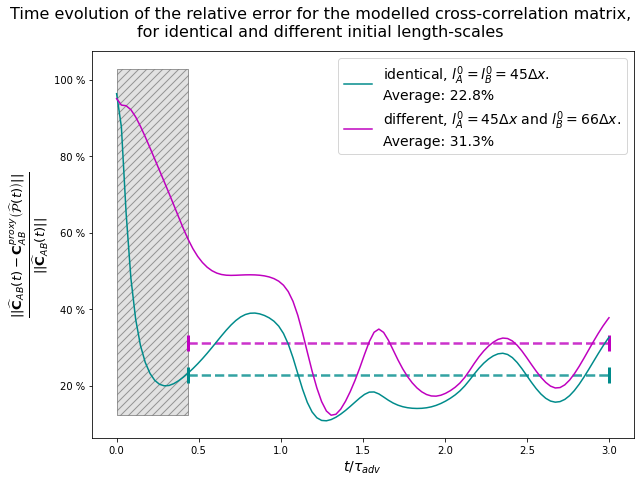

In [20]:
fig, ax = plt.subplots(1,1,figsize=(18*0.5,6.8))
fig.suptitle("Time evolution of the relative error for the modelled cross-correlation matrix,\n"+\
             fr"for identical and different initial length-scales",fontsize=16)

label = 'identical, '+ fr"$l_A^0=l_B^0={int(lhA*Nx)} \Delta x$"+ f'. \nAverage: {mean_on_period_homogeneous:.1f}%' #+r', || $\cdot$ || Frobenius norm'
ax.plot(saved_times/Tadv, np.array(relatives_errors_fro_homogeneous) *100 ,c='darkcyan',label=label)

index_mean = np.arange(15, len(diag_enkf.keys())).astype(int)
times_mean_homogeneous = np.array(saved_times)[index_mean] 
mean_on_period_homogeneous = np.mean(np.array(relatives_errors_fro_homogeneous)[index_mean])*100

# ax.plot(times_mean_homogeneous/Tadv,
#          np.zeros(len(index_mean)) + mean_on_period_homogeneous,
#         label=f'average homo. case: {mean_on_period_homogeneous:.1f}%',c='darkcyan',linestyle='--',
#          zorder=1.0,linewidth=2.5,alpha=0.8)

ax.plot(times_mean_homogeneous/Tadv,
         np.zeros(len(index_mean)) + mean_on_period_homogeneous,
        c='darkcyan',linestyle='--',
         zorder=1.0,linewidth=2.5,alpha=0.8)

ax.scatter(times_mean_homogeneous[[0,-1]]/Tadv, [mean_on_period_homogeneous]*2,marker='|',linewidth=3,s=[250]*2,c='darkcyan')
yticks = [20,40,60,80,100]
yticklabels = [str(tick) +' %' for tick in yticks]
ax.set_yticks(ticks=yticks,labels=yticklabels)
# ax.set_title(fr"(a) homogeneous case, $l_A^0=l_B^0={int(lhA*Nx)} \Delta x$",fontsize=15.5)
ax.set_xlabel(r'$t/\tau_{adv}$',fontsize=14);
ax.set_ylabel(r'$\frac{||\widehat{\mathbf{C}}_{AB}(t) - \mathbf{C}^{proxy}_{AB}\left(\widehat{\mathcal{P}}(t)\right)  ||}{|| \widehat{\mathbf{C}}_{AB}(t) ||}$',
              fontsize=19);


# ax.fill_betweenx([relatives_errors_fro_homogeneous[0]*100,np.min(relatives_errors_fro_homogeneous)*100],
#                   times_mean_homogeneous[0]/Tadv,0,color='lightgrey',hatch='///', edgecolor='dimgrey',lw=1,zorder=0,alpha=.65)



label = f'different, '+ fr"$l_A^0={int(lhA*Nx)} \Delta x$ and $l_B^0={int(lhB*Nx)} \Delta x$"+ f'.\nAverage: {mean_on_period_heterogeneous:.1f}%' #+r', || $\cdot$ || Frobenius norm'
ax.plot(saved_times/Tadv, np.array(relatives_errors_fro_hetero) *100 ,c='m',label=label)

# index_mean = np.arange(20, len(diag_enkf.keys())).astype(int)
times_mean_heterogeneous = np.array(saved_times)[index_mean] 
mean_on_period_heterogeneous = np.mean(np.array(relatives_errors_fro_hetero)[index_mean])*100

# ax.plot(times_mean_heterogeneous/Tadv,
#          np.zeros(len(index_mean)) + mean_on_period_heterogeneous,
#         label=f'average hetero. case: {mean_on_period_heterogeneous:.1f}%',c='m',linestyle='--',
#          zorder=1.0,linewidth=2.5,alpha=0.8)
ax.plot(times_mean_heterogeneous/Tadv,
         np.zeros(len(index_mean)) + mean_on_period_heterogeneous,c='m',linestyle='--',
         zorder=1.0,linewidth=2.5,alpha=0.8)

ax.scatter(times_mean_heterogeneous[[0,-1]]/Tadv, [mean_on_period_heterogeneous]*2,marker='|',linewidth=3,s=[250]*2,c='m')

leg = ax.legend(prop={'size': 14})
label1, label2 = leg.get_texts()
# label4.set_size('14')
# label2.set_size('14')


ax.fill_betweenx([103,np.min(relatives_errors_fro_hetero)*100],
                  times_mean_heterogeneous[0]/Tadv,0,color='lightgrey',hatch='///', edgecolor='dimgrey',lw=1,zorder=0,alpha=.65)

fig.tight_layout();
fig.savefig(f'../figures/Nx{Nx}/time_evolution_relative_error_modelled_CCmat_heterogeneous_case_Nx{Nx}_homogeneous_and_heterogeneous')

# 3. Multivariate formulation of the PKF dynamics with SymPKF <a class="anchor" id="multivariate-formulation-pkf"></a>

To determine the parameters composing the PKF system, we need to propose a parametrized modelization of the cross-correlation functions, in order to have a complete modelization of the covariances. To do so, we forecast an EnKF to allow cross-correlations functions to appear. Then, we diagnose some parameters and recombine them in order to approximate the cross-correlation functions. These parameters will then consitute the PKF system of parameters. We will then focus on deriving the dynamics of these parameters.

In [13]:
pkf_system = SymbolicPKF(LV_dynamics)
for equation in pkf_system.in_aspect: display(equation)

Eq(Derivative(A(t, x), t), k_1*A(t, x) - k_2*A(t, x)*B(t, x) - k_2*V_AB(t, x) - A(t, x)*Derivative(u(x), x) - u(x)*Derivative(A(t, x), x))

Eq(Derivative(B(t, x), t), k_2*A(t, x)*B(t, x) + k_2*V_AB(t, x) - k_3*B(t, x) - B(t, x)*Derivative(u(x), x) - u(x)*Derivative(B(t, x), x))

Eq(Derivative({V_{A}}(t, x), t), 2*k_1*{V_{A}}(t, x) - 2*k_2*A(t, x)*V_AB(t, x) - 2*k_2*B(t, x)*{V_{A}}(t, x) - u(x)*Derivative({V_{A}}(t, x), x) - 2*{V_{A}}(t, x)*Derivative(u(x), x))

Eq(Derivative({V_{B}}(t, x), t), 2*k_2*A(t, x)*{V_{B}}(t, x) + 2*k_2*B(t, x)*V_AB(t, x) - 2*k_3*{V_{B}}(t, x) - u(x)*Derivative({V_{B}}(t, x), x) - 2*{V_{B}}(t, x)*Derivative(u(x), x))

Eq(Derivative(V_AB(t, x), t), k_1*V_AB(t, x) + k_2*A(t, x)*V_AB(t, x) - k_2*A(t, x)*{V_{B}}(t, x) - k_2*B(t, x)*V_AB(t, x) + k_2*B(t, x)*{V_{A}}(t, x) - k_3*V_AB(t, x) - V_AB(t, x)*u(x)*Derivative({V_{B}}(t, x), x)/(2*{V_{B}}(t, x)) - V_AB(t, x)*u(x)*Derivative({V_{A}}(t, x), x)/(2*{V_{A}}(t, x)) - 2*V_AB(t, x)*Derivative(u(x), x) - u(x)*sqrt({V_{A}}(t, x))*sqrt({V_{B}}(t, x))*Expectation({\varepsilon_{A}}(t, x, omega)*Derivative({\varepsilon_{B}}(t, x, omega), x)) - u(x)*sqrt({V_{A}}(t, x))*sqrt({V_{B}}(t, x))*Expectation({\varepsilon_{B}}(t, x, omega)*Derivative({\varepsilon_{A}}(t, x, omega), x)))

Eq(Derivative({s_{A,xx}}(t, x), t), -2*k_2*A(t, x)*V_AB(t, x)*{s_{A,xx}}(t, x)/{V_{A}}(t, x) + 2*k_2*A(t, x)*sqrt({V_{B}}(t, x))*{s_{A,xx}}(t, x)**2*Expectation(Derivative({\varepsilon_{A}}(t, x, omega), x)*Derivative({\varepsilon_{B}}(t, x, omega), x))/sqrt({V_{A}}(t, x)) + k_2*A(t, x)*{s_{A,xx}}(t, x)**2*Expectation({\varepsilon_{B}}(t, x, omega)*Derivative({\varepsilon_{A}}(t, x, omega), x))*Derivative({V_{B}}(t, x), x)/(sqrt({V_{A}}(t, x))*sqrt({V_{B}}(t, x))) - k_2*A(t, x)*sqrt({V_{B}}(t, x))*{s_{A,xx}}(t, x)**2*Expectation({\varepsilon_{B}}(t, x, omega)*Derivative({\varepsilon_{A}}(t, x, omega), x))*Derivative({V_{A}}(t, x), x)/{V_{A}}(t, x)**(3/2) + 2*k_2*sqrt({V_{B}}(t, x))*{s_{A,xx}}(t, x)**2*Expectation({\varepsilon_{B}}(t, x, omega)*Derivative({\varepsilon_{A}}(t, x, omega), x))*Derivative(A(t, x), x)/sqrt({V_{A}}(t, x)) - u(x)*Derivative({s_{A,xx}}(t, x), x) + 2*{s_{A,xx}}(t, x)*Derivative(u(x), x))

Eq(Derivative({s_{B,xx}}(t, x), t), 2*k_2*B(t, x)*V_AB(t, x)*{s_{B,xx}}(t, x)/{V_{B}}(t, x) - 2*k_2*B(t, x)*sqrt({V_{A}}(t, x))*{s_{B,xx}}(t, x)**2*Expectation(Derivative({\varepsilon_{A}}(t, x, omega), x)*Derivative({\varepsilon_{B}}(t, x, omega), x))/sqrt({V_{B}}(t, x)) + k_2*B(t, x)*sqrt({V_{A}}(t, x))*{s_{B,xx}}(t, x)**2*Expectation({\varepsilon_{A}}(t, x, omega)*Derivative({\varepsilon_{B}}(t, x, omega), x))*Derivative({V_{B}}(t, x), x)/{V_{B}}(t, x)**(3/2) - k_2*B(t, x)*{s_{B,xx}}(t, x)**2*Expectation({\varepsilon_{A}}(t, x, omega)*Derivative({\varepsilon_{B}}(t, x, omega), x))*Derivative({V_{A}}(t, x), x)/(sqrt({V_{A}}(t, x))*sqrt({V_{B}}(t, x))) - 2*k_2*sqrt({V_{A}}(t, x))*{s_{B,xx}}(t, x)**2*Expectation({\varepsilon_{A}}(t, x, omega)*Derivative({\varepsilon_{B}}(t, x, omega), x))*Derivative(B(t, x), x)/sqrt({V_{B}}(t, x)) - u(x)*Derivative({s_{B,xx}}(t, x), x) + 2*{s_{B,xx}}(t, x)*Derivative(u(x), x))

- These dynamics are not closed (see aspect tensors dynamics). To solve this issue, we explore the role played by the open terms on the anisotropy dynamics in the next notebook.